# Mol-2-Vec (NLP) with CATBoost for Partition Coefficient-LogP Predictions 

(2296, 9)
Morgan fingerprints dataset shape: (2296, 2048)
Learning rate set to 0.045068
0:	learn: 31.7145995	total: 3.68ms	remaining: 3.67s
100:	learn: 23.9777270	total: 332ms	remaining: 2.96s
200:	learn: 22.5825840	total: 643ms	remaining: 2.55s
300:	learn: 21.1507200	total: 948ms	remaining: 2.2s
400:	learn: 20.2657013	total: 1.25s	remaining: 1.87s
500:	learn: 19.5865268	total: 1.55s	remaining: 1.55s
600:	learn: 19.0238707	total: 1.85s	remaining: 1.23s
700:	learn: 18.6444645	total: 2.16s	remaining: 921ms
800:	learn: 18.2841669	total: 2.61s	remaining: 649ms
900:	learn: 17.9784381	total: 3.07s	remaining: 337ms
999:	learn: 17.7463312	total: 3.53s	remaining: 0us
Test MAE: 12.07226360516571
Test RMSE: 20.86838697770654
Test R2: 0.631740808421983


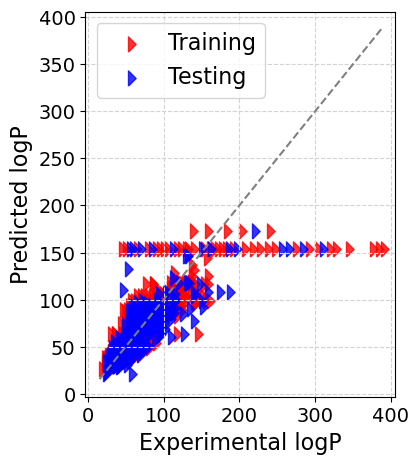

In [2]:
import math
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from gensim.models import word2vec
from sklearn import preprocessing
from catboost import CatBoostRegressor

# Reading organic solvents viscosity data

input_dir = 'D:/Postdoc-Work/Manuacripts/NLP-Organic_Solvents-Properties/Comm Chemistry/Revisions_R1/Data_ML-pred/Morgan-FP/VOC/'
dataset = pd.read_csv(input_dir + 'VOC-Database.csv', encoding='unicode_escape')

# Sorting dataset with unique SMILES
dataset = dataset.drop_duplicates(subset=['SMILES']).sort_values(by='SMILES')

print(dataset.shape)

mol_smiles = dataset['SMILES']
enthalpy_vap = dataset['dvap']

# Calculate Morgan fingerprints using RDKit
def morgan_fingerprints(smiles, radius=2, n_bits=2048):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits) for mol in mols]
    # Convert the fingerprints to a DataFrame
    fingerprints_array = [list(fp) for fp in fingerprints]
    return pd.DataFrame(fingerprints_array)

# Function call to calculate Morgan fingerprints
fingerprints_df = morgan_fingerprints(dataset['SMILES'])

print("Morgan fingerprints dataset shape:", fingerprints_df.shape)




# Simple train-test split
X_train, X_test, y_train, y_test, smiles_train, smiles_test = train_test_split(
    fingerprints_df, enthalpy_vap, mol_smiles, test_size=0.2, random_state=536)

# Train CatBoost
cat_model = CatBoostRegressor(verbose=100)
cat_model.fit(X_train, y_train)

# Predict on train
y_pred_train = cat_model.predict(X_train)
train_df = pd.DataFrame({
    'SMILES': smiles_train.reset_index(drop=True),
    'viscosity_actual': y_train.reset_index(drop=True),
    'viscosity_vap_pred': y_pred_train
})
train_df.to_csv('CATBoost_MorganFP-Training_Enthalpy-Vap_536Seed.csv', index=False)

# Predict on test
y_pred_test = cat_model.predict(X_test)
test_df = pd.DataFrame({
    'SMILES': smiles_test.reset_index(drop=True),
    'viscosity_actual': y_test.reset_index(drop=True),
    'viscosity_pred': y_pred_test
})
test_df.to_csv('CATBoost_MorganFP-Testing_Enthalpy-Vap_536Seed.csv', index=False)

# Print metrics
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
print("Test RMSE:", math.sqrt(mean_squared_error(y_test, y_pred_test)))
print("Test R2:", r2_score(y_test, y_pred_test))

# Scatterplot
plt.figure(figsize=(4, 5))
ln = np.arange(min(min(y_train), min(y_test)), max(max(y_train), max(y_test)), 0.2)
plt.plot(ln, ln, 'gray', linestyle='--')

plt.scatter(y_train, y_pred_train, color='red', label='Training', alpha=0.8,
            marker=MarkerStyle("D", fillstyle="right"), s=60)
plt.scatter(y_test, y_pred_test, color='blue', label='Testing', alpha=0.8,
            marker=MarkerStyle("D", fillstyle="right"), s=60)

plt.xlabel('Experimental logP', fontsize=16)
plt.ylabel('Predicted logP', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(color='#D3D3D3', linestyle='--', which='both', axis='both')
plt.legend(loc='upper left', fontsize=16)
# plt.savefig('CATBoost_Mol2vec-LogP_Comm-Chem-RS536-25000.png', dpi=1200, bbox_inches='tight')
plt.show()


